In [2]:
!pip install -U keras-tuner

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import set_printoptions

from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow import keras
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from keras.models import Sequential
from keras_tuner.tuners import RandomSearch
from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings('ignore')

In [4]:
forest_fire = pd.read_csv('forestfires.csv')
pd.set_option('display.max_columns', 31)
forest_fire

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,large
513,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,large
514,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,large
515,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,small


In [5]:
fire_data = forest_fire.drop(forest_fire.columns[[11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]], axis=1)


In [6]:
fire_data


,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,small
...,...,...,...,...,...,...,...,...,...,...,...,...
512,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,large
513,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,large
514,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,large
515,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,small


In [7]:
fire_data.shape


(517, 12)

In [8]:
fire_data.describe().T


,count,mean,std,min,25%,50%,75%,max
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40
area,517.0,12.847292,63.655818,0.0,0.0,0.52,6.57,1090.84


In [9]:
fire_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [10]:
fire_data.isnull().sum()


month            0
day              0
FFMC             0
DMC              0
DC               0
ISI              0
temp             0
RH               0
wind             0
rain             0
area             0
size_category    0
dtype: int64

In [11]:
fire_data[fire_data.duplicated()]


,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
53,aug,wed,92.1,111.2,654.1,9.6,20.4,42,4.9,0.0,0.00,small
100,aug,sun,91.4,142.4,601.4,10.6,19.8,39,5.4,0.0,0.00,small
215,mar,sat,91.7,35.8,80.8,7.8,17.0,27,4.9,0.0,28.66,large
303,jun,fri,91.1,94.1,232.1,7.1,19.2,38,4.5,0.0,0.00,small
426,aug,thu,91.6,248.4,753.8,6.3,20.4,56,2.2,0.0,0.00,small
461,aug,sat,93.7,231.1,715.1,8.4,18.9,64,4.9,0.0,0.00,small
501,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00,small
508,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.00,small


In [12]:
# List of Numerical Variables
numerical_features = [feature for feature in fire_data.columns if fire_data[feature].dtypes != 'O']
print('Number of numerical variables:', len(numerical_features))

# Visualize the numerical variables
fire_data[numerical_features].head()

Number of numerical variables: 9


,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [13]:
discrete_feature = [feature for feature in numerical_features if len(fire_data[feature].unique())<25]
print('Discrete Variables Count: {}'.format(len(discrete_feature)))

Discrete Variables Count: 2


In [14]:
continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature]
print('Continuous Feature Count {}'.format(len(continuous_feature)))


Continuous Feature Count 7


In [15]:
categorical = [var for var in fire_data.columns if fire_data[var].dtype=='O']
print('There are {} categorical variables\n'.format(len(categorical)))
print('The categorical variables are :\n\n', categorical)


There are 3 categorical variables

The categorical variables are :

 ['month', 'day', 'size_category']


In [17]:
# Frequency counts of categorical variables


In [16]:
for var in categorical:

    print(fire_data[var].value_counts())

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64
sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64
small    378
large    139
Name: size_category, dtype: int64


In [18]:
for var in categorical:

    print(fire_data[var].value_counts()/np.float(len(fire_data)))

aug    0.355899
sep    0.332689
mar    0.104449
jul    0.061896
feb    0.038685
jun    0.032882
oct    0.029014
apr    0.017408
dec    0.017408
jan    0.003868
may    0.003868
nov    0.001934
Name: month, dtype: float64
sun    0.183752
fri    0.164410
sat    0.162476
mon    0.143133
tue    0.123791
thu    0.117988
wed    0.104449
Name: day, dtype: float64
small    0.731141
large    0.268859
Name: size_category, dtype: float64


In [19]:
for var in categorical:

    print(var, ' contains ', len(fire_data[var].unique()), ' labels')

month  contains  12  labels
day  contains  7  labels
size_category  contains  2  labels


In [20]:
fire_data.corr()


,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
FFMC,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.040122
DMC,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.072994
DC,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.049383
ISI,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.008258
temp,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.097844
RH,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.075519
wind,-0.028485,-0.105342,-0.203466,0.106826,-0.227116,0.069410,1.000000,0.061119,0.012317
rain,0.056702,0.074790,0.035861,0.067668,0.069491,0.099751,0.061119,1.000000,-0.007366
area,0.040122,0.072994,0.049383,0.008258,0.097844,-0.075519,0.012317,-0.007366,1.000000


In [21]:
# 4. Data Visualization
# 4.1 Univariate plots

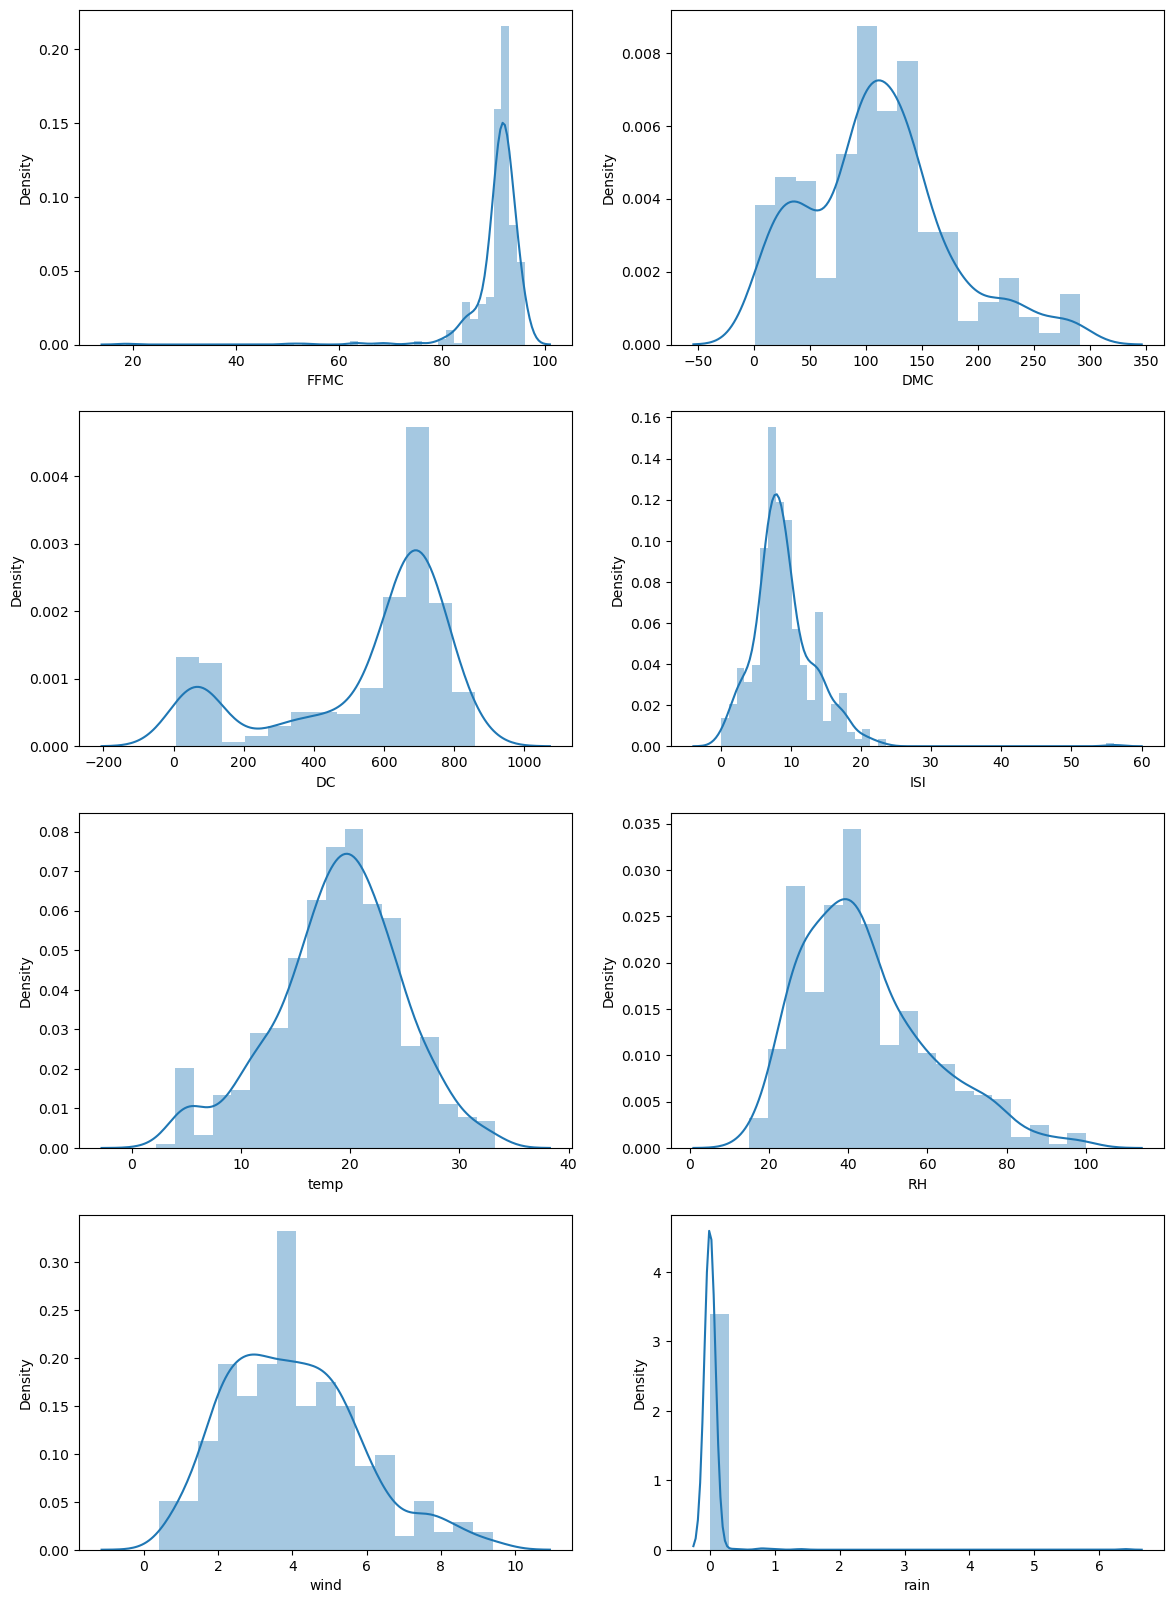

In [22]:
fig, ax = plt.subplots(4,2, figsize = (14,20))

sns.distplot(fire_data.FFMC, ax = ax[0,0])
sns.distplot(fire_data.DMC, ax = ax[0,1])
sns.distplot(fire_data.DC, ax = ax[1,0])
sns.distplot(fire_data.ISI, ax = ax[1,1])
sns.distplot(fire_data.temp, ax = ax[2,0])
sns.distplot(fire_data.RH, ax = ax[2,1])
sns.distplot(fire_data.wind, ax = ax[3,0])
sns.distplot(fire_data.rain, ax = ax[3,1])

plt.show()

In [23]:
#4.2 Outliers Detection


In [24]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in df.columns.tolist():
        Q1 = np.percentile(df[col],25)    # 1st quartile (25%)
        Q3 = np.percentile(df[col],75)    # 3rd quartile (75%)
        IQR = Q3 - Q1                     # Interquartile rrange (IQR)

        outlier_step = 1.5 * IQR          # outlier step

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )

    return multiple_outliers

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(forest_fire[continuous_feature]))))

The dataset contains 3 observations with more than 2 outliers


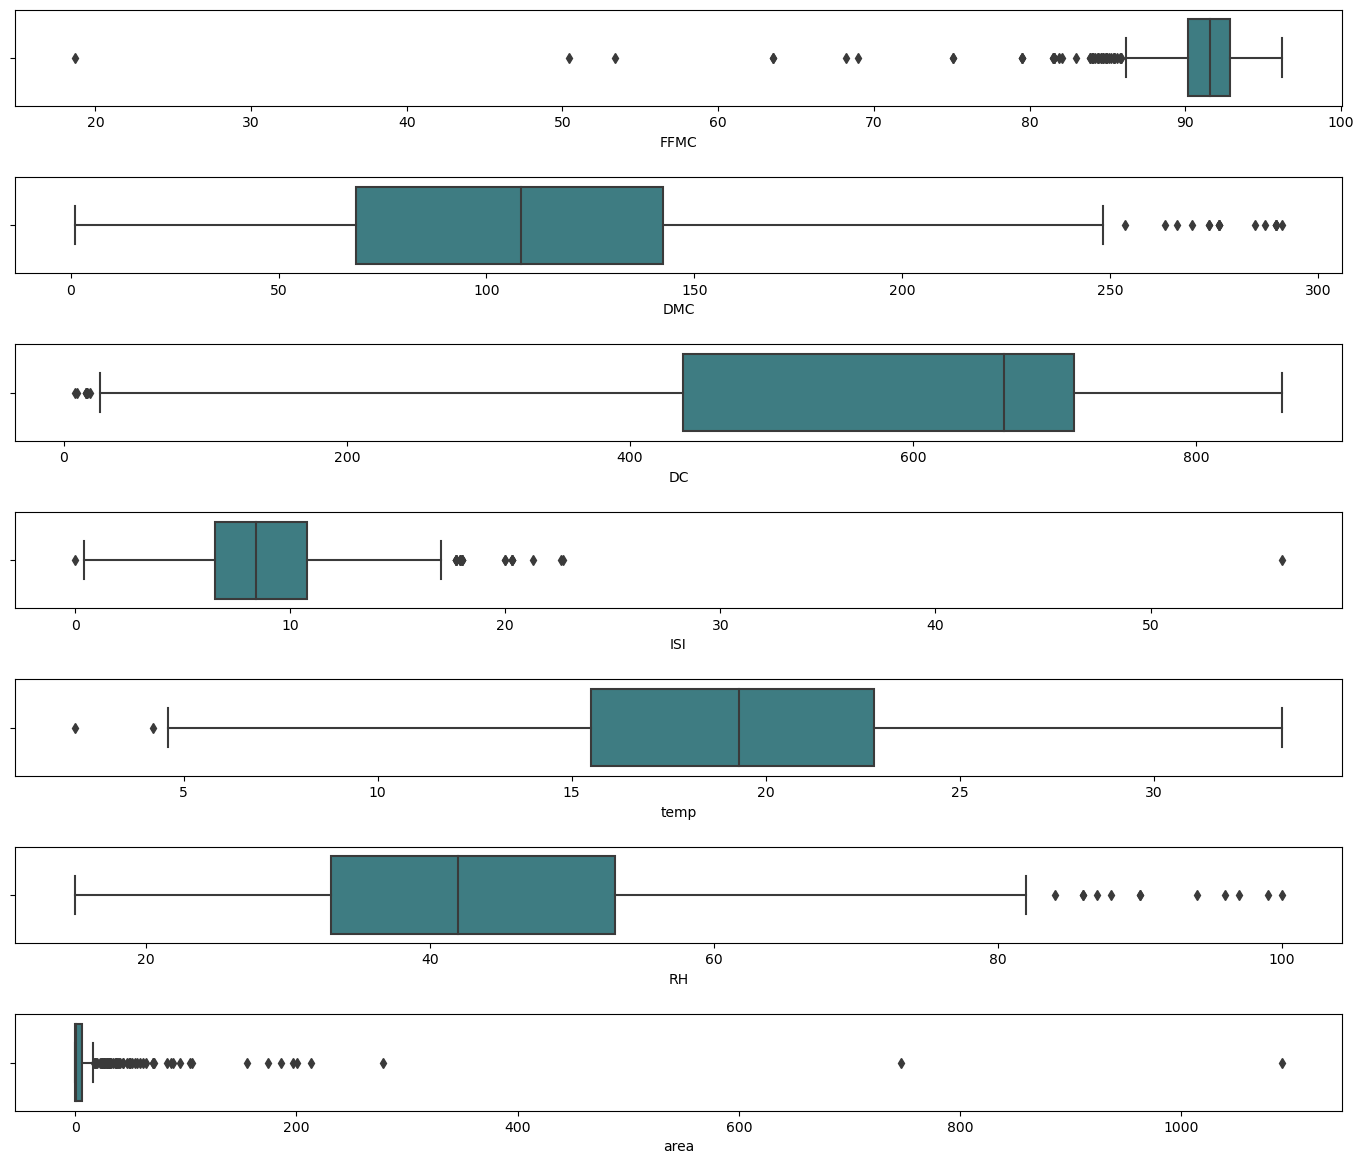

In [25]:
outlier = fire_data.copy()
fig, axes=plt.subplots(7,1,figsize=(14,12),sharex=False,sharey=False)
sns.boxplot(x='FFMC',data=outlier,palette='crest',ax=axes[0])
sns.boxplot(x='DMC',data=outlier,palette='crest',ax=axes[1])
sns.boxplot(x='DC',data=outlier,palette='crest',ax=axes[2])
sns.boxplot(x='ISI',data=outlier,palette='crest',ax=axes[3])
sns.boxplot(x='temp',data=outlier,palette='crest',ax=axes[4])
sns.boxplot(x='RH',data=outlier,palette='crest',ax=axes[5])
sns.boxplot(x='area',data=outlier,palette='crest',ax=axes[6])
plt.tight_layout(pad=2.0)

In [26]:
# After Log-Transformation


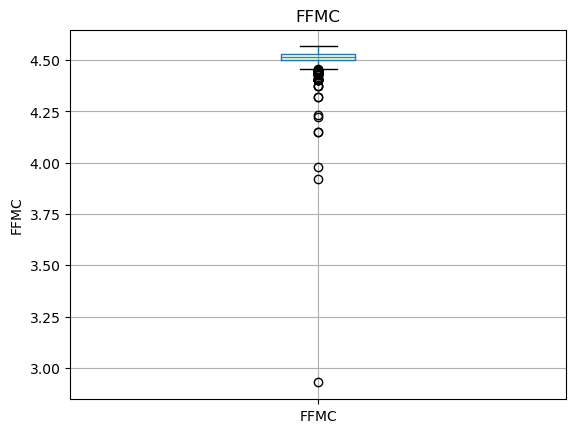

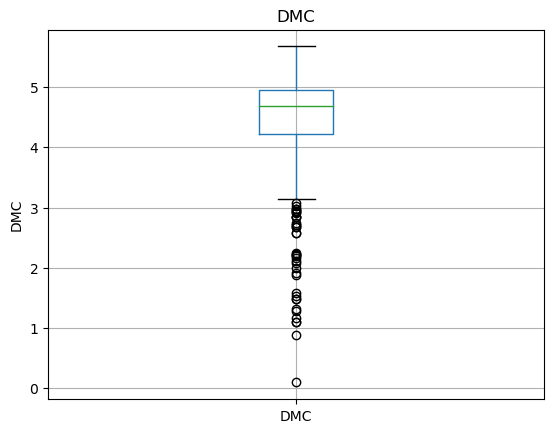

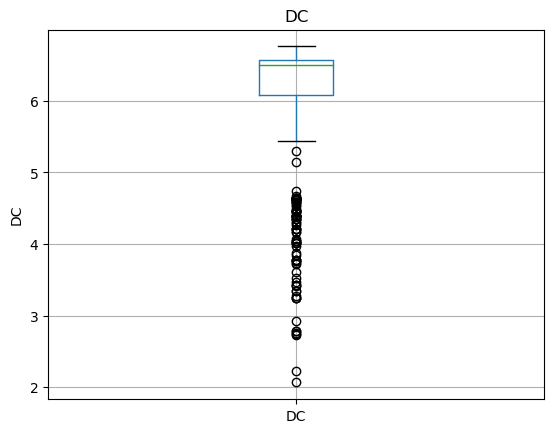

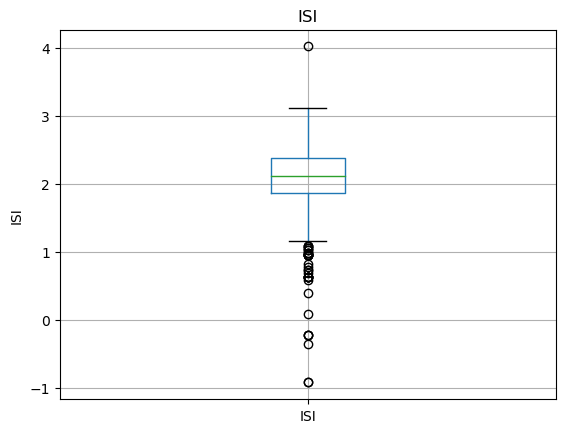

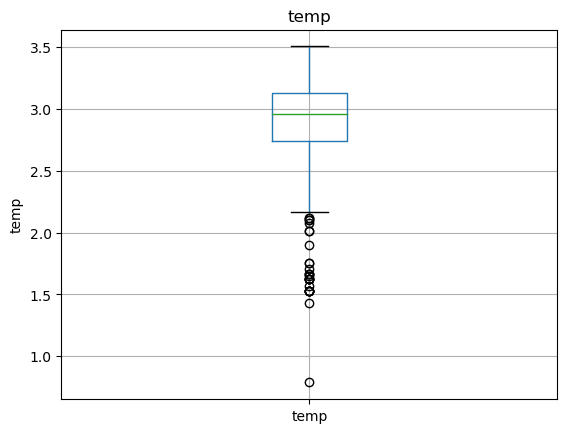

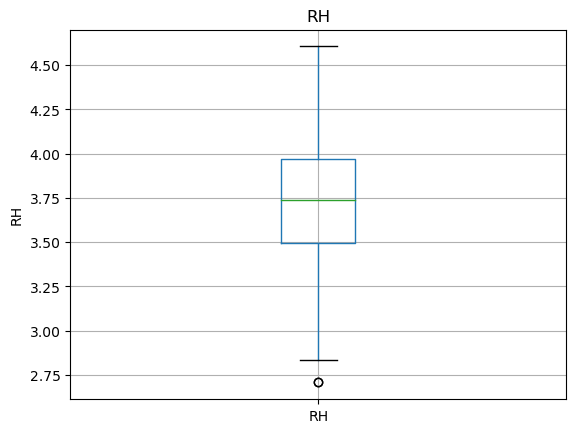

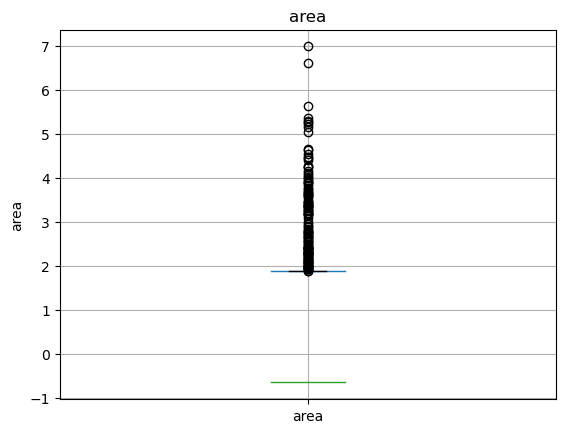

In [27]:
for feature in continuous_feature:
    data = fire_data.copy()
    data[feature]=np.log(data[feature])
    data.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

Skew: 12.846933533934868
Kurtosis: 194.1407210942299


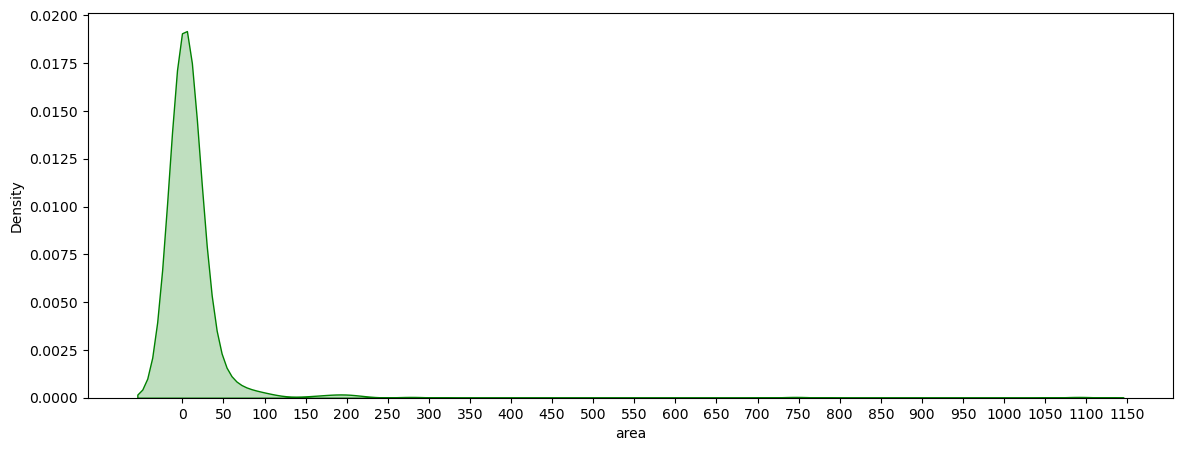

In [28]:
plt.figure(figsize=(14,5))
print("Skew: {}".format(fire_data['area'].skew()))
print("Kurtosis: {}".format(fire_data['area'].kurtosis()))
ax = sns.kdeplot(fire_data['area'],shade=True,color='g')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

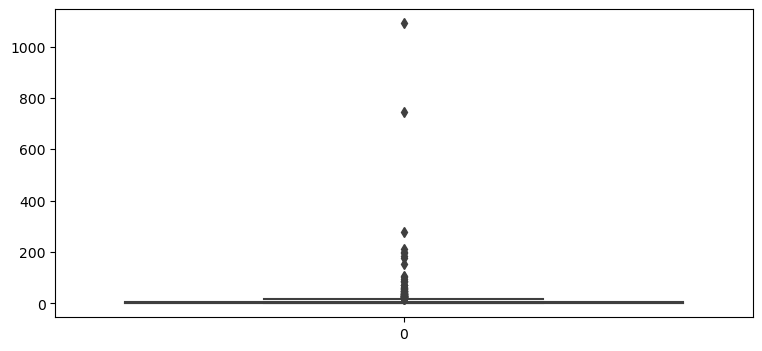

In [29]:
plt.figure(figsize=(9,4))
sns.boxplot(fire_data['area']);

In [30]:
# 4.4 Categorical Variables


In [31]:
categorical_features=[feature for feature in fire_data.columns if fire_data[feature].dtype=='O']
print('Number of Categorical Features:',len(categorical_features), '\n', categorical_features)
forest_fire[categorical_features].head()

Number of Categorical Features: 3 
 ['month', 'day', 'size_category']


,month,day,size_category
0,mar,fri,small
1,oct,tue,small
2,oct,sat,small
3,mar,fri,small
4,mar,sun,small


In [32]:
for feature in categorical_features:
    print("{} number of unique categories in feature named {}".format(len(fire_data[feature].unique()),feature))

12 number of unique categories in feature named month
7 number of unique categories in feature named day
2 number of unique categories in feature named size_category


In [33]:
# Decide which categorical variables you want to use in model


In [34]:
for feature in fire_data.columns:
    if fire_data[feature].dtypes == 'object':      # in pandas it is object
        unique_cat = len(fire_data[feature].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=feature, unique_cat=unique_cat))
        print(fire_data[feature].value_counts())
        print()

Feature 'month' has 12 unique categories
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

Feature 'day' has 7 unique categories
sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64

Feature 'size_category' has 2 unique categories
small    378
large    139
Name: size_category, dtype: int64



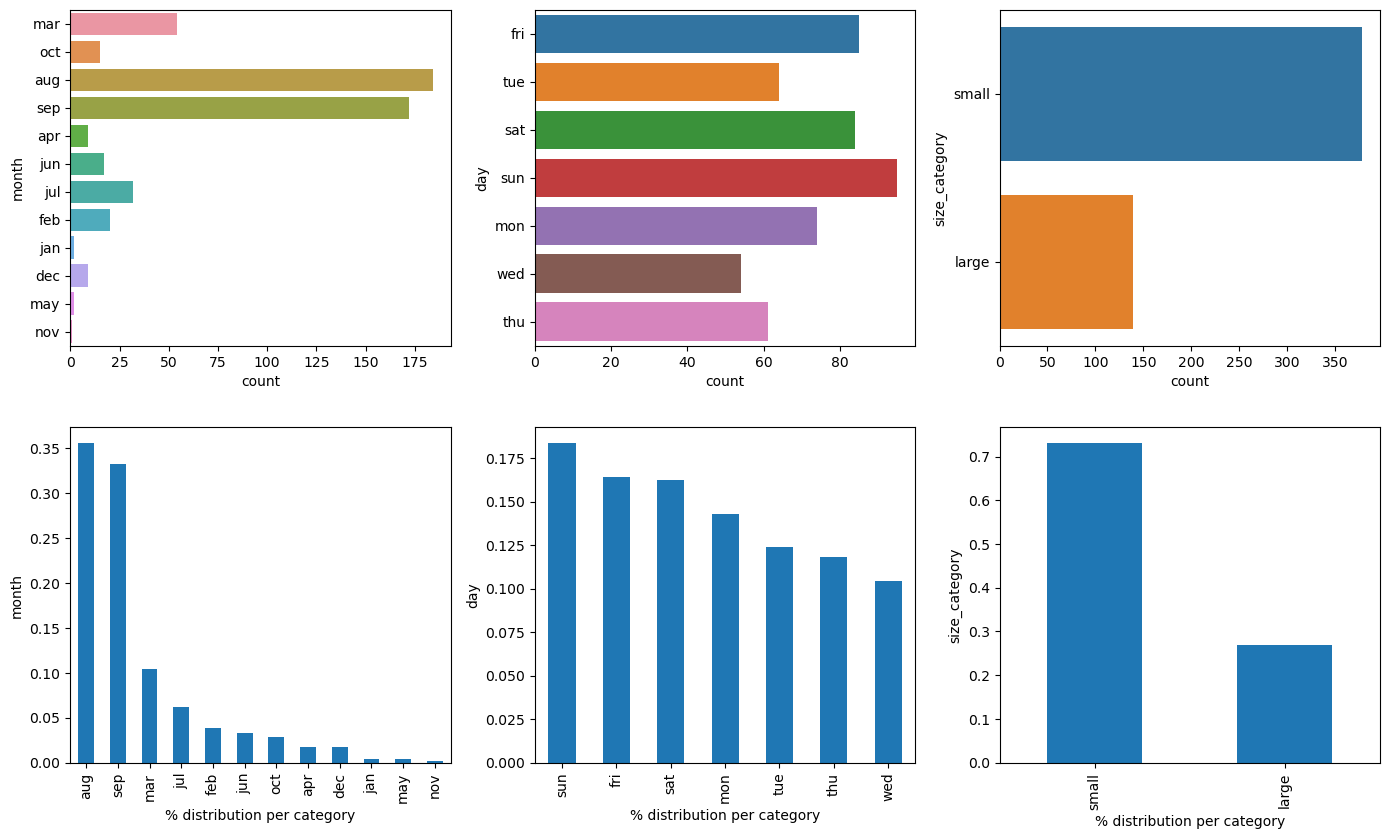

In [35]:
plt.figure(figsize=(14,12))
for i,col in enumerate(categorical_features,1):
    plt.subplot(3,3,i)
    sns.countplot(data = fire_data,y=col)
    plt.subplot(3,3,i+3)
    fire_data[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()

In [36]:
print(fire_data['area'].describe(),'\n')
# A categorical variable based on forest fire area damage
# No damage, low, moderate, high, very high

df = fire_data.copy()
def area_cat(area):
    if area == 0.0:
        return "No damage"
    elif area <= 1:
        return "low"
    elif area <= 25:
        return "moderate"
    elif area <= 100:
        return "high"
    else:
        return "very high"

df['damage_category'] = df['area'].apply(area_cat)
df.head()

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64 



,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category,damage_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,small,No damage
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,small,No damage
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,small,No damage
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,small,No damage
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,small,No damage


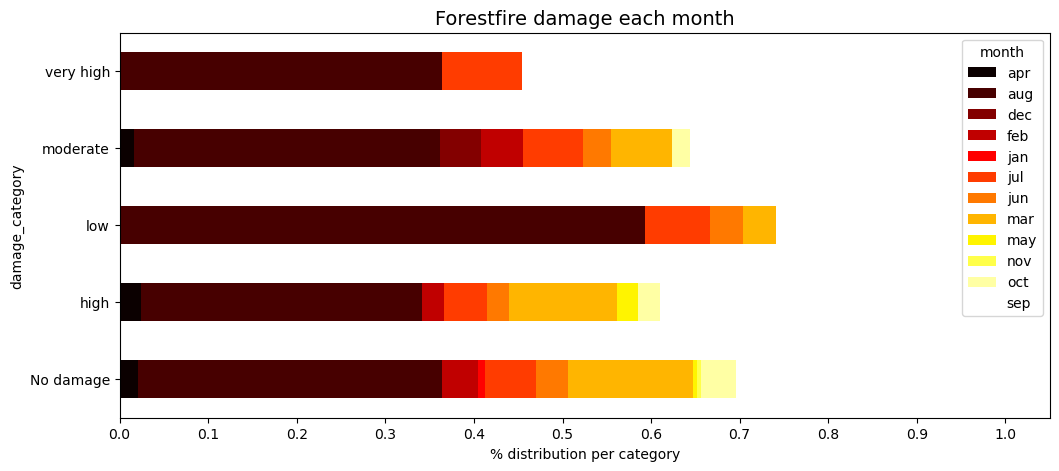

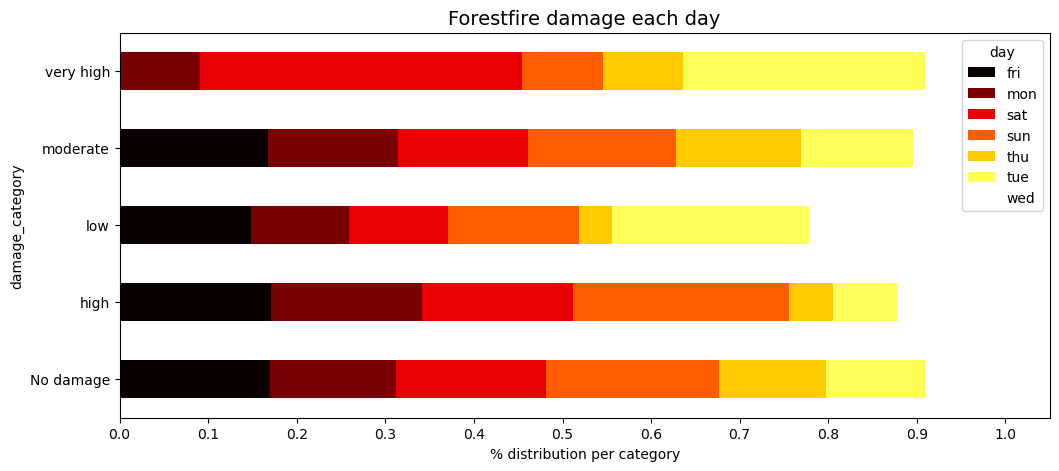

In [37]:
for col in categorical_features:
    if col!="size_category":
        cross = pd.crosstab(index=df['damage_category'],columns=df[col],normalize='index')
        cross.plot.barh(stacked=True,cmap='hot',figsize=(12,5))
        plt.xlabel('% distribution per category')
        plt.xticks(np.arange(0,1.1,0.1))
        plt.title("Forestfire damage each {}".format(col), fontsize=14)

plt.show()

In [38]:
# Setting parameters


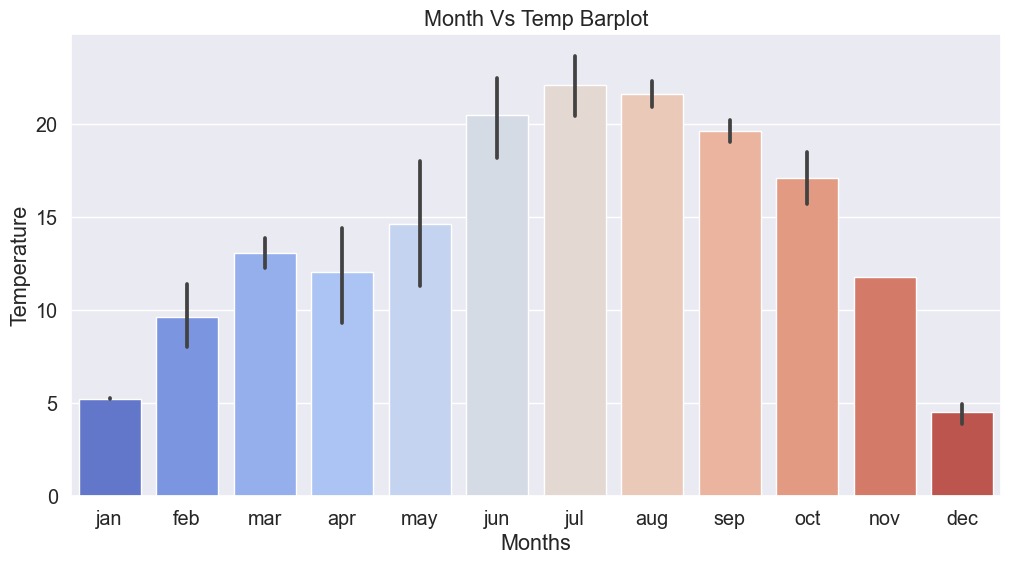

In [39]:
plt.rcParams['figure.figsize'] = [12,6]
sns.set(style = "darkgrid", font_scale = 1.3)
month_temp = sns.barplot(x = 'month', y = 'temp', data = fire_data,
                         order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], palette = 'coolwarm')
month_temp.set(title = "Month Vs Temp Barplot", xlabel = "Months", ylabel = "Temperature");


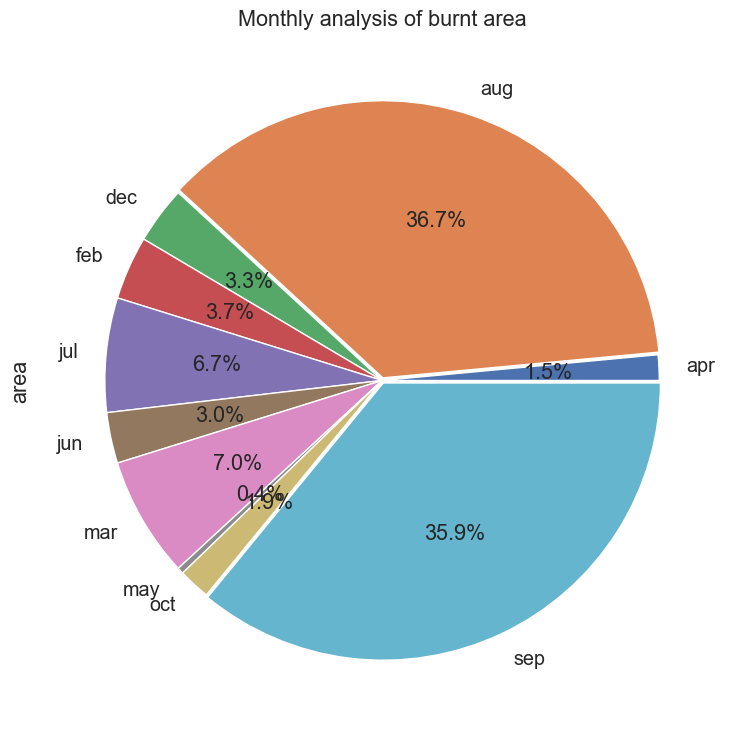

In [40]:
areaburnt = fire_data[fire_data['area']>0]
areaburnt.groupby('month')['area'].agg('count').plot(kind='pie',title='Monthly analysis of burnt area',figsize=(9,9),explode=[0,0.01,0,0,0,0,0,0,0,0.01],autopct='%0.1f%%')
plt.show()

In [41]:
df1 = fire_data.copy()
order = {'month':{'jan':'January','feb':'February','mar':'March','apr':'April','may':'May','jun':'June','jul':'July','aug':'August','sep':'September','oct':'October','nov':'November','dec':'December'}}
df1 = df1.replace(order)

count_month_response_pct = pd.crosstab(df1['size_category'],df1['month']).apply(lambda x: x/x.sum() * 100)
count_month_response_pct = count_month_response_pct.transpose()
month = pd.DataFrame(df1['month'].value_counts())
month['% Small Forest Fire'] = count_month_response_pct['small']
month['% Large Forest Fire'] = count_month_response_pct['large']
month.drop('month',axis = 1,inplace = True)
month['index'] = [8,9,3,7,2,6,10,4,12,1,5,11]
month = month.sort_values('index',ascending = True)
month.drop('index', axis=1,inplace=True)
month

,% Small Forest Fire,% Large Forest Fire
January,100.000000,0.000000
February,70.000000,30.000000
March,77.777778,22.222222
April,77.777778,22.222222
May,50.000000,50.000000
June,82.352941,17.647059
July,71.875000,28.125000
August,76.630435,23.369565
September,70.348837,29.651163
October,73.333333,26.666667


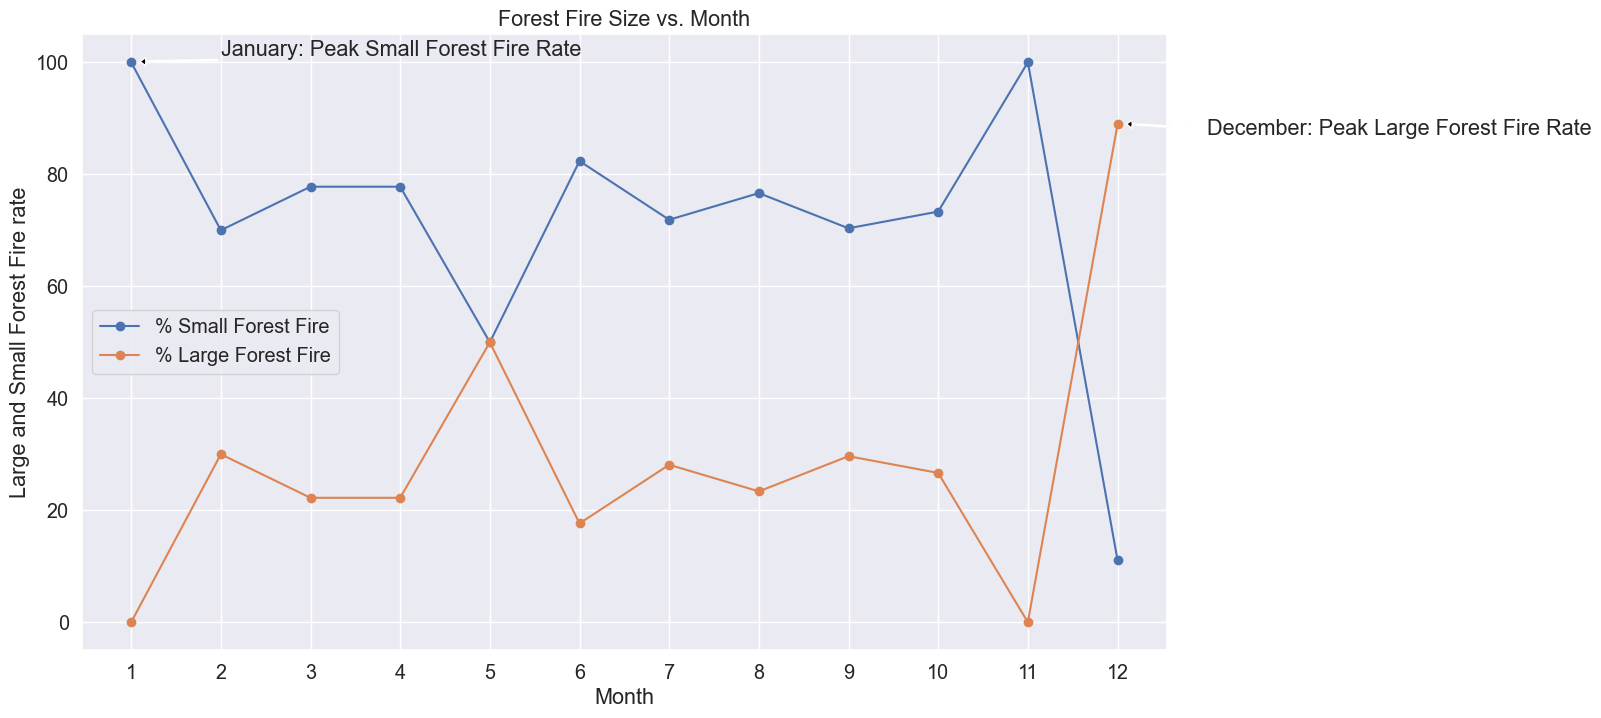

In [42]:
df1 = fire_data.copy()
order = {'month':{'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}}
df1 = df1.replace(order)

count_month_response_pct = pd.crosstab(df1['size_category'],df1['month']).apply(lambda x: x/x.sum() * 100)
count_month_response_pct = count_month_response_pct.transpose()
month = pd.DataFrame(df1['month'].value_counts())
month['% Small Forest Fire'] = count_month_response_pct['small']
month['% Large Forest Fire'] = count_month_response_pct['large']
month.drop('month',axis = 1,inplace = True)
month['Month'] = ['August','September','March','July','February','June','October','April','December','January','May','November']
month['index'] = [8,9,3,7,2,6,10,4,12,1,5,11]
month = month.sort_values('index',ascending = True)
month.drop('index', axis=1,inplace=True)
plot_month = month[['% Small Forest Fire','% Large Forest Fire']].plot(kind ='line', figsize = (14,8), marker = 'o')

plt.title('Forest Fire Size vs. Month')
plt.ylabel('Large and Small Forest Fire rate')
plt.xlabel('Month')

ticks = np.arange(1,13,1)
plt.xticks(ticks)

# Annotation: peak of Small fire rate
y = month['% Small Forest Fire'].max()
x = month['% Small Forest Fire'].idxmax()
plt.annotate('January: Peak Small Forest Fire Rate', xy=(x+0.1, y+0.1), xytext=(x+1,y+4), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

# Annotation: peak of large fire rate
y = month['% Large Forest Fire'].max()
x = month['% Large Forest Fire'].idxmax()
plt.annotate('December: Peak Large Forest Fire Rate', xy=(x+0.1, y+0.1), xytext=(x+1,y+1), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

plt.show()

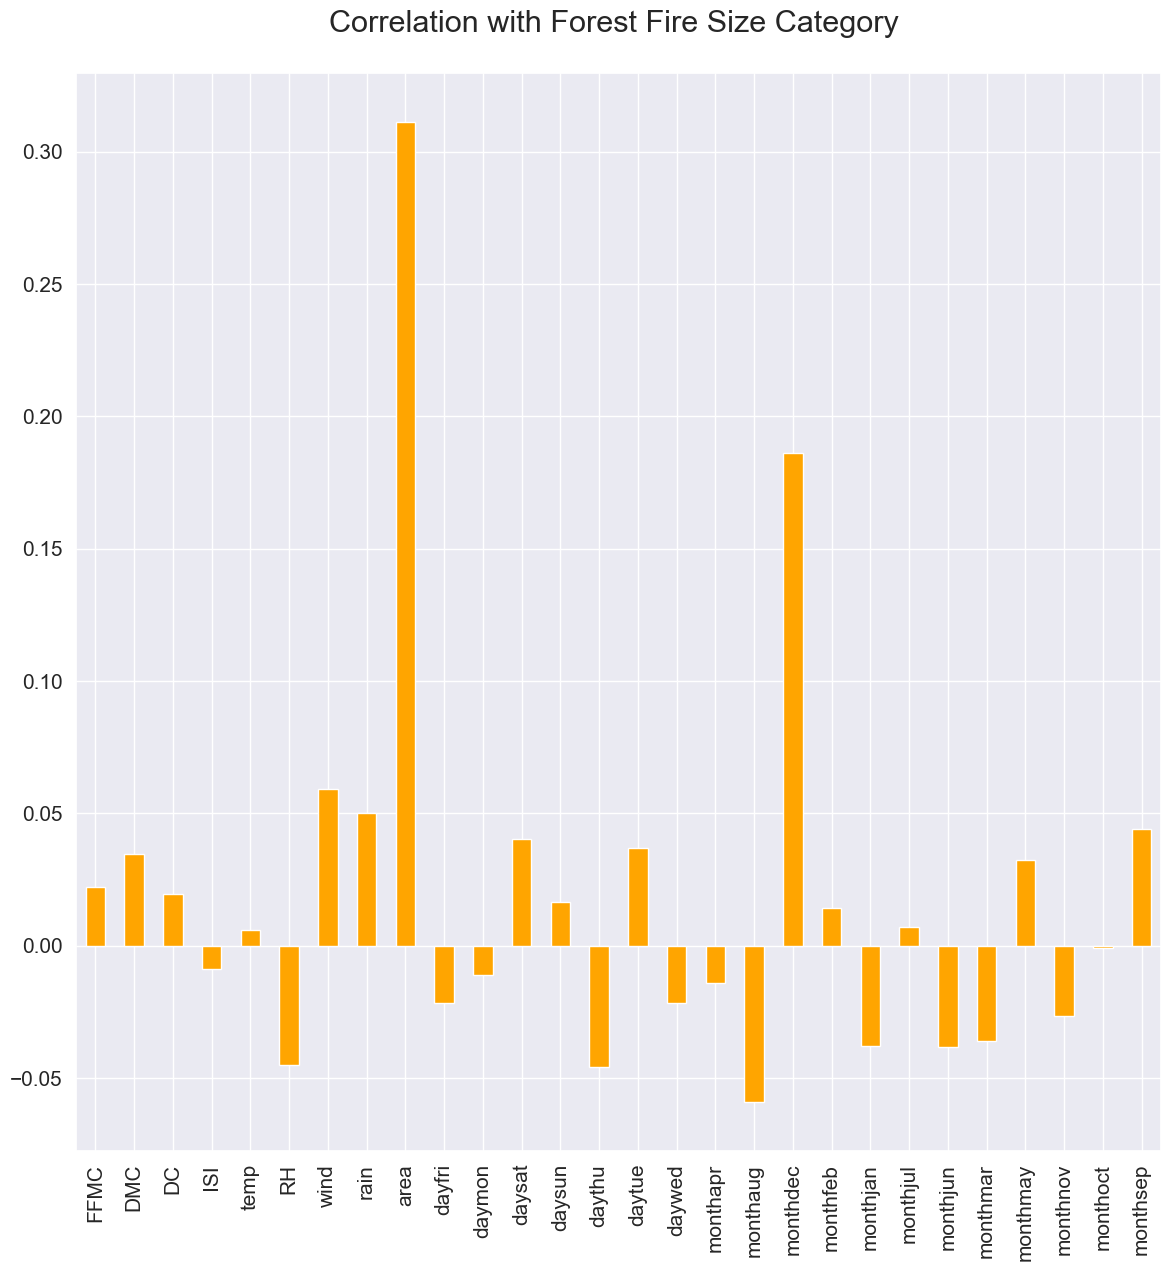

In [43]:
df = fire_data.copy()
df['size_category'] = np.where(df['size_category'].str.contains("large"), 1, 0)

correlations = forest_fire.corrwith(df.size_category)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(figsize= (14,14), fontsize = 15, color = 'orange', rot = 90, grid = True)
plt.title('Correlation with Forest Fire Size Category \n', horizontalalignment="center", fontstyle = "normal",
fontsize = "22", fontfamily = "sans-serif");

In [44]:
# 4.7 Analysis of the response column


In [45]:
fire_data.size_category.unique()


array(['small', 'large'], dtype=object)

In [46]:
countsizesmall = len(fire_data[fire_data.size_category == 'small'])
countsizelarge = len(fire_data[fire_data.size_category == 'large'])
print("Percentage of Small Forest Fire Size: {:.2f}%".format((countsizesmall / (len(fire_data.size_category))*100)))
print("Percentage of Large Foreset Fire Size: {:.2f}%".format((countsizelarge / (len(fire_data.size_category))*100)))

Percentage of Small Forest Fire Size: 73.11%
Percentage of Large Foreset Fire Size: 26.89%


In [47]:
fire_data.size_category.value_counts()


small    378
large    139
Name: size_category, dtype: int64

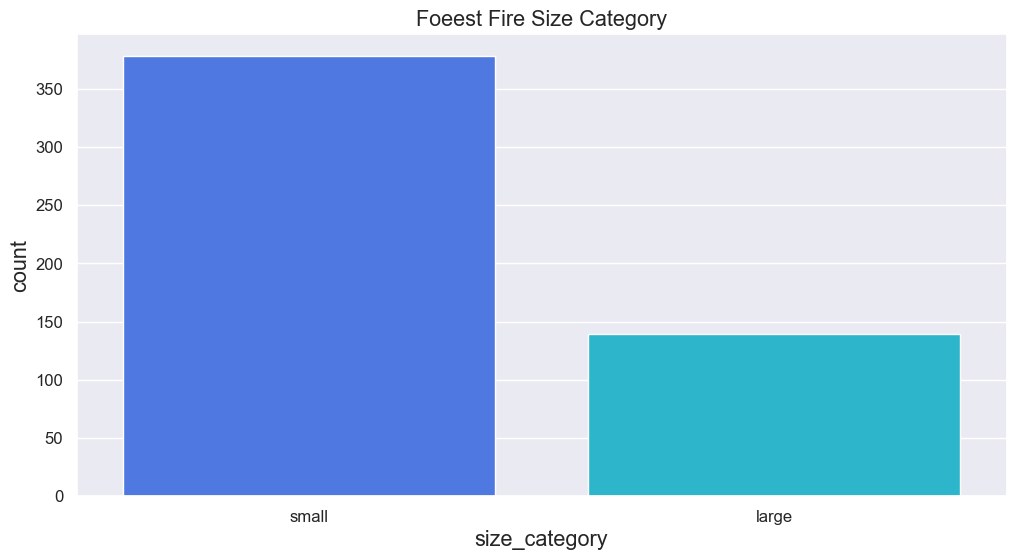

In [48]:
pal = sns.color_palette('rainbow')
sns.countplot(x='size_category', data= fire_data, palette = pal, order= fire_data['size_category'].value_counts().index)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Foeest Fire Size Category');

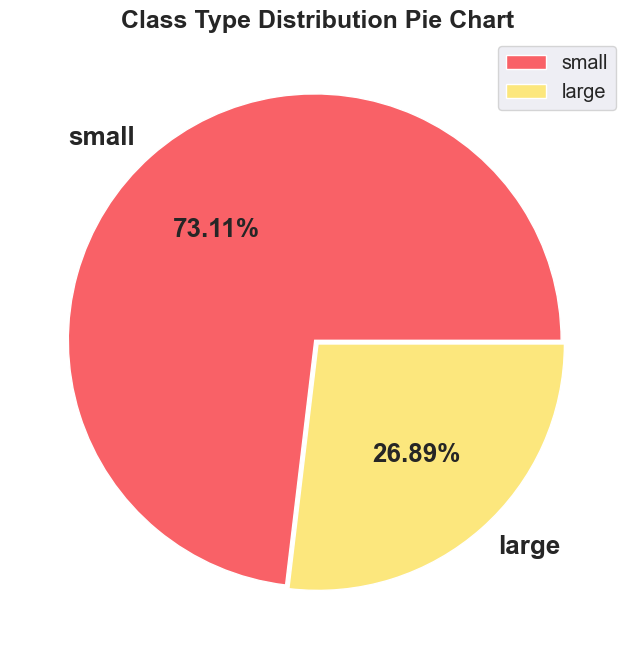

In [49]:
plt.figure(figsize = (8,8))
plt.pie(fire_data['size_category'].value_counts(), labels= fire_data.size_category.unique(),
        explode = [0.02,0.0], autopct= '%.2f%%', colors = ["#F96167", "#FCE77D"],
        textprops = {'size':'large', 'fontweight':'bold',})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

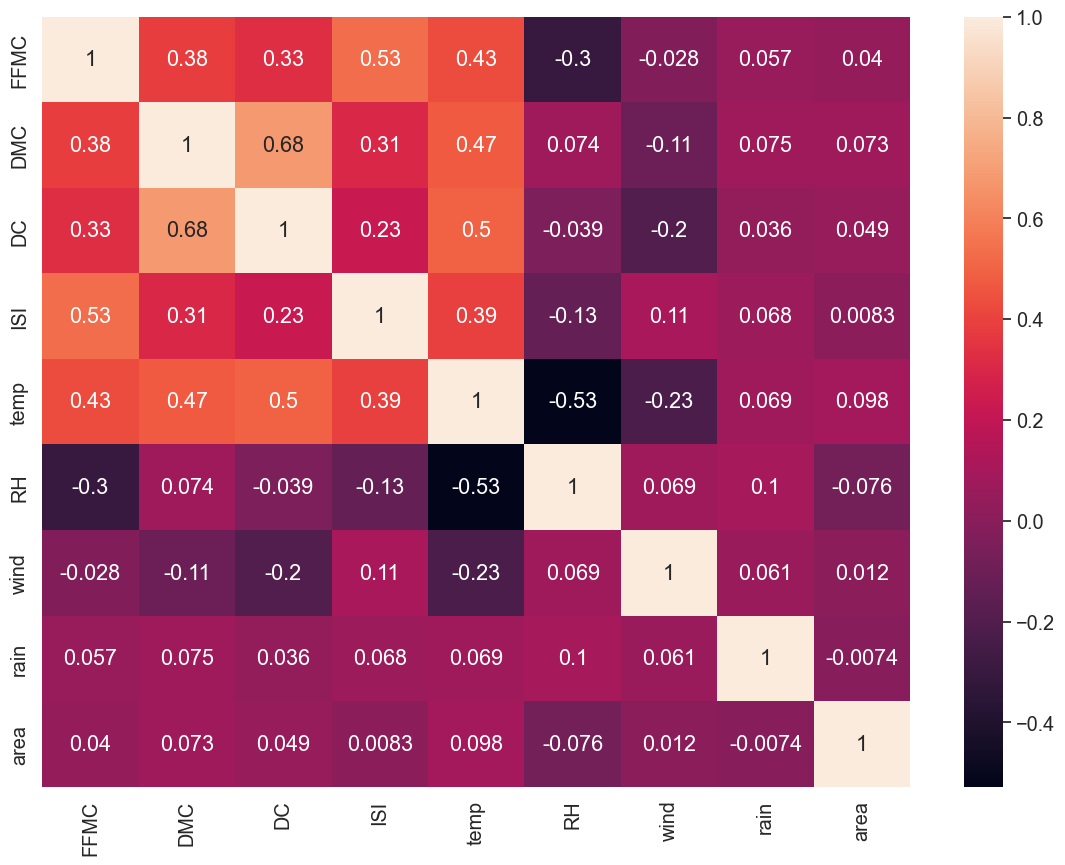

In [50]:
fig= plt.figure(figsize=(14,10))
sns.heatmap(fire_data.corr(), annot=True);
plt.xticks(rotation=90);

In [52]:
#Data Pre-Processing
#5.1. Feature Engineering

In [54]:
continuous_feature=[feature for feature in fire_data.columns if fire_data[feature].dtype!='O']
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 9


In [55]:
fire_data[continuous_feature]


,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [56]:

df_standard_scaled = fire_data.copy()
features = df_standard_scaled[continuous_feature]

In [57]:
scaler = StandardScaler()

df_standard_scaled[continuous_feature] = scaler.fit_transform(features.values)
df_standard_scaled.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,mar,fri,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,-0.20202,small
1,oct,tue,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,-0.20202,small
2,oct,sat,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,-0.20202,small
3,mar,fri,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,-0.20202,small
4,mar,sun,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,-0.20202,small


In [58]:
print('Mean' '\n',np.round(df_standard_scaled.mean(),1))


Mean
 FFMC   -0.0
DMC    -0.0
DC      0.0
ISI     0.0
temp    0.0
RH      0.0
wind   -0.0
rain   -0.0
area    0.0
dtype: float64


In [59]:
print('Standard Devaition','\n',np.round(df_standard_scaled.std()),1)


Standard Devaition 
 FFMC    1.0
DMC     1.0
DC      1.0
ISI     1.0
temp    1.0
RH      1.0
wind    1.0
rain    1.0
area    1.0
dtype: float64 1


In [60]:
df = df_standard_scaled.copy()
df.drop('size_category',axis=1, inplace =True)
df = pd.get_dummies(df.iloc[:,:])
df.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,-0.20202,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,-0.20202,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,-0.20202,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,-0.20202,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,-0.20202,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [61]:
# 5.2. Converting Categorical Variable into Label by using Get Dummies FeatureData Pre-Processing

In [62]:
# Converting string value into binary classes such as if "large" than classify it as '1' else 'O'
df['size_category'] = fire_data.size_category
df['size_category'] = np.where(df['size_category'].str.contains("large"), 1, 0)
df.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,size_category
0,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,-0.20202,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,-0.20202,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,-0.20202,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,-0.20202,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,-0.20202,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [63]:
df.size_category.unique()


array([0, 1])

In [64]:
# 6. Feature Selection Technique


In [65]:
forest_fire.drop(['month','day','area'] ,axis=1, inplace= True)


In [66]:
data1 = forest_fire.copy()
data1.drop('size_category',axis=1, inplace =True)
data1 = pd.get_dummies(data1.iloc[:,:-1])
data1.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [67]:
data1['size_category'] = df1.size_category
data1.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,size_category
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,small
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,small
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,small
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,small
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,small


In [68]:
le = LabelEncoder()
le.fit(data1["size_category"])
data1["size_category"]=le.transform(data1["size_category"])
data1.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,dayfri,daymon,daysat,daysun,daythu,daytue,daywed,monthapr,monthaug,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,size_category
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [69]:
X = data1.drop('size_category', axis = 1)
y=  data1.size_category

In [70]:
# Feature Extraction


In [71]:
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, y)

In [72]:
# Summarize Scores


In [73]:
scores = fit.scores_
features = fit.transform(X)
score_df = pd.DataFrame(list(zip(scores, X.columns)), columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

,Score,Feature
1,23.006108,DMC
2,21.872657,DC
17,17.601210,monthdec
5,6.350054,RH
7,5.216072,rain
6,1.440661,wind
16,1.157358,monthaug
12,0.964276,daythu
21,0.738170,monthjun
19,0.735450,monthjan


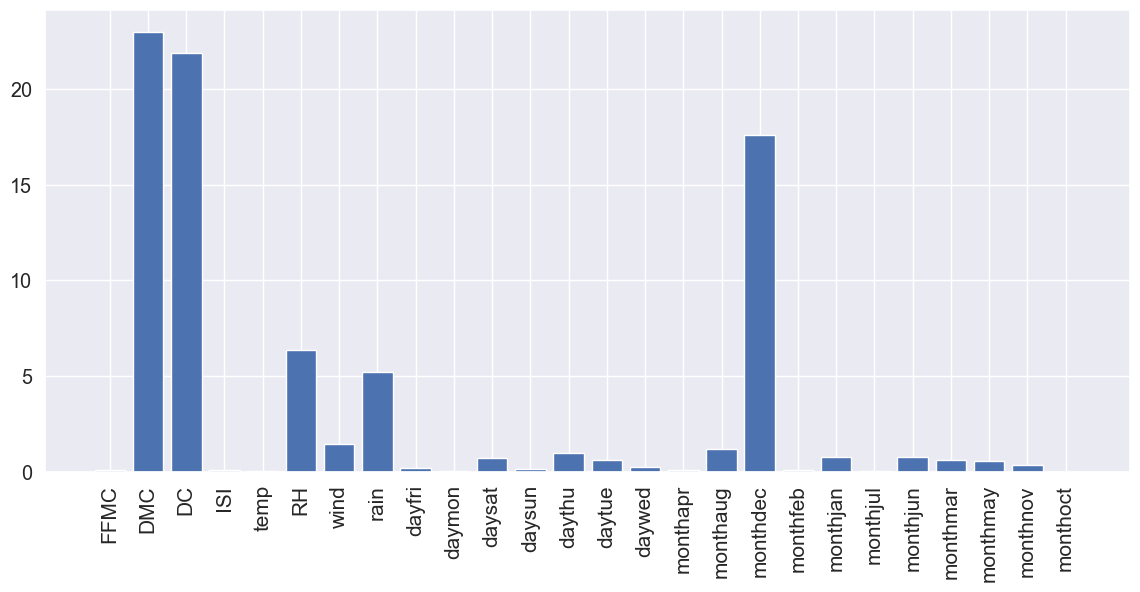

In [74]:
fig, axes = plt.subplots(figsize=(14,6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks(range(len(scores)))
axes.set_xticklabels(X.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

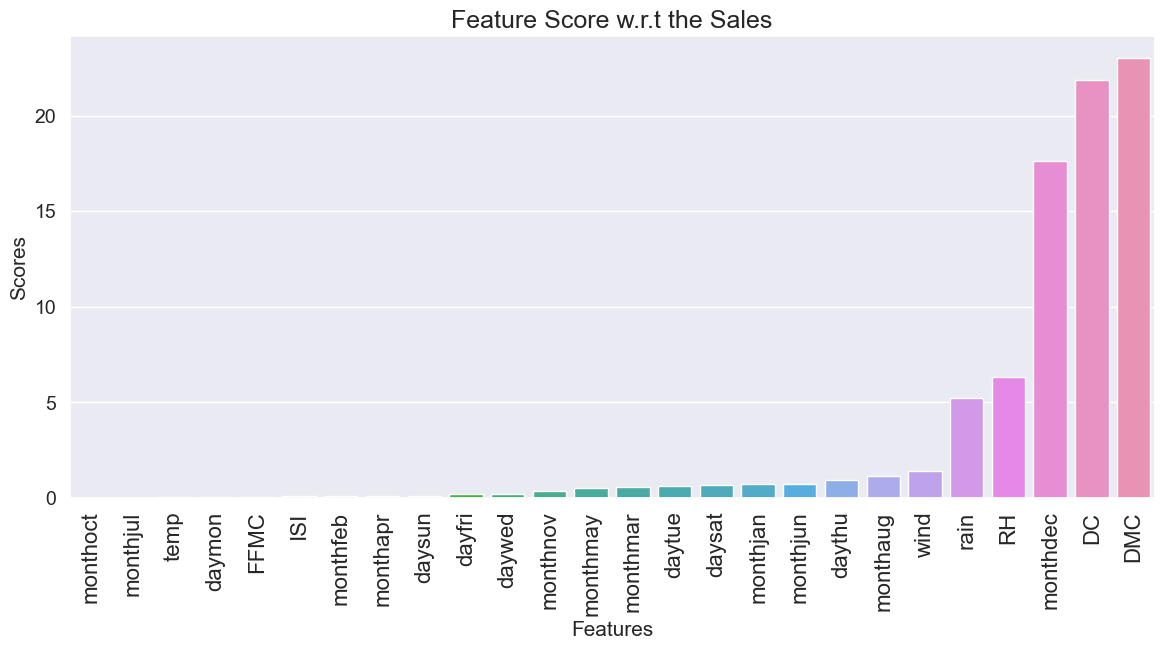

In [75]:
plt.figure(figsize=(14,6))
sns.barplot(x= 'Feature', y= "Score", data= score_df, order= score_df.sort_values('Score').Feature)
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the Sales", size=18)
plt.show()

In [76]:
model_data=df[['DMC','DC','RH','rain','wind','area','month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep','size_category']]
model_data

,DMC,DC,RH,rain,wind,area,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,size_category
0,-1.323326,-1.830477,0.411724,-0.073268,1.498614,-0.202020,0,0,0,0,0,0,0,1,0,0,0,0,0
1,-1.179541,0.488891,-0.692456,-0.073268,-1.741756,-0.202020,0,0,0,0,0,0,0,0,0,0,1,0,0
2,-1.049822,0.560715,-0.692456,-0.073268,-1.518282,-0.202020,0,0,0,0,0,0,0,0,0,0,1,0,0
3,-1.212361,-1.898266,3.233519,0.603155,-0.009834,-0.202020,0,0,0,0,0,0,0,1,0,0,0,0,0
4,-0.931043,-1.798600,3.356206,-0.073268,-1.238940,-0.202020,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,-0.846648,0.474768,-0.753800,-0.073268,-0.736124,-0.100753,0,1,0,0,0,0,0,0,0,0,0,0,1
513,-0.846648,0.474768,1.638592,-0.073268,0.995798,0.651674,0,1,0,0,0,0,0,0,0,0,0,0,1
514,-0.846648,0.474768,1.577248,-0.073268,1.498614,-0.026532,0,1,0,0,0,0,0,0,0,0,0,0,1
515,0.549003,0.269382,-0.140366,-0.073268,-0.009834,-0.202020,0,1,0,0,0,0,0,0,0,0,0,0,0


In [77]:
# 6.1 Test Train Split With Imbalanced Dataset


In [78]:
x = model_data.drop('size_category',axis=1)
y = model_data[['size_category']]

In [79]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3, stratify=y)
len(x_train.columns)

18

In [80]:
# 7. Hyperparameter Tuning
# 7.1 Hyperparameter Tuning: Optimal Learning rate ,Number of Layers and Neurons

In [81]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=100, step=32), activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [82]:
tuner = RandomSearch(build_model, objective= 'val_accuracy', max_trials= 5,
                     executions_per_trial=3, directory= 'project', project_name= 'Forest Fire')
tuner.search_space_summary()

Reloading Tuner from project\Forest Fire\tuner0.json
Search space summary
Default search space size: 14
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_v

In [83]:
tuner.search(x_train, y_train, epochs= 100, validation_data= (x_test, y_test))


In [84]:
tuner.results_summary()


Results summary
Results in project\Forest Fire
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
num_layers: 6
units_0: 32
units_1: 96
learning_rate: 0.01
units_2: 64
units_3: 32
units_4: 64
units_5: 96
units_6: 32
units_7: 32
units_8: 64
units_9: 32
units_10: 32
units_11: 96
Score: 0.9850427508354187

Trial 3 summary
Hyperparameters:
num_layers: 12
units_0: 96
units_1: 32
learning_rate: 0.01
units_2: 96
units_3: 96
units_4: 96
units_5: 32
units_6: 96
units_7: 64
units_8: 64
units_9: 96
units_10: 64
units_11: 32
Score: 0.9807692368825277

Trial 1 summary
Hyperparameters:
num_layers: 4
units_0: 96
units_1: 64
learning_rate: 0.01
units_2: 96
units_3: 96
units_4: 32
units_5: 96
units_6: 96
units_7: 64
units_8: 32
units_9: 32
units_10: 64
Score: 0.9786324699719747

Trial 0 summary
Hyperparameters:
num_layers: 11
units_0: 96
units_1: 32
learning_rate: 0.01
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 

In [85]:
# 7.2 Hyperparameter Tuning: Optimal Batch_size, Number of Epochs


In [86]:
def create_model():
    model1 = Sequential()
    model1.add(Dense(64,input_dim=18,activation='relu'))
    model1.add(Dense(64,activation='relu'))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(units=1,activation="sigmoid"))

    adam = Adam(learning_rate=0.01)
    model1.compile(loss='binary_crossentropy',optimizer = adam,metrics=["accuracy"])
    return model1

In [87]:
model1 = KerasClassifier(build_fn= create_model, verbose=0)
batch_size = [10,20,40,50]
epochs = [10,50,100,200]
param_grid = dict(batch_size= batch_size, epochs=epochs)
grid = GridSearchCV(estimator= model1, param_grid= param_grid, cv= KFold(), verbose= 10)

In [89]:
grid_result = grid.fit(x_test,y_test)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START batch_size=10, epochs=10...................................
[CV 1/5; 1/16] END ....batch_size=10, epochs=10;, score=0.844 total time=   1.2s
[CV 2/5; 1/16] START batch_size=10, epochs=10...................................
[CV 2/5; 1/16] END ....batch_size=10, epochs=10;, score=0.806 total time=   1.2s
[CV 3/5; 1/16] START batch_size=10, epochs=10...................................
[CV 3/5; 1/16] END ....batch_size=10, epochs=10;, score=0.935 total time=   1.6s
[CV 4/5; 1/16] START batch_size=10, epochs=10...................................
[CV 4/5; 1/16] END ....batch_size=10, epochs=10;, score=0.871 total time=   1.0s
[CV 5/5; 1/16] START batch_size=10, epochs=10...................................
[CV 5/5; 1/16] END ....batch_size=10, epochs=10;, score=0.935 total time=   1.4s
[CV 1/5; 2/16] START batch_size=10, epochs=50...................................
[CV 1/5; 2/16] END ....batch_size=10, epochs=50;

[CV 1/5; 11/16] END ..batch_size=40, epochs=100;, score=0.875 total time=   2.0s
[CV 2/5; 11/16] START batch_size=40, epochs=100.................................
[CV 2/5; 11/16] END ..batch_size=40, epochs=100;, score=0.968 total time=   1.6s
[CV 3/5; 11/16] START batch_size=40, epochs=100.................................
[CV 3/5; 11/16] END ..batch_size=40, epochs=100;, score=0.968 total time=   1.6s
[CV 4/5; 11/16] START batch_size=40, epochs=100.................................
[CV 4/5; 11/16] END ..batch_size=40, epochs=100;, score=0.968 total time=   1.9s
[CV 5/5; 11/16] START batch_size=40, epochs=100.................................
[CV 5/5; 11/16] END ..batch_size=40, epochs=100;, score=0.968 total time=   2.0s
[CV 1/5; 12/16] START batch_size=40, epochs=200.................................
[CV 1/5; 12/16] END ..batch_size=40, epochs=200;, score=0.844 total time=   3.0s
[CV 2/5; 12/16] START batch_size=40, epochs=200.................................
[CV 2/5; 12/16] END ..batch_

In [90]:
print('Best {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{}, {} with {}".format(mean,stdev,param))

Best 0.9558467626571655, using {'batch_size': 40, 'epochs': 200}
0.8784274220466614, 0.050891185498252695 with {'batch_size': 10, 'epochs': 10}
0.9556451439857483, 0.04221371222927085 with {'batch_size': 10, 'epochs': 50}
0.9427419185638428, 0.046214671852652336 with {'batch_size': 10, 'epochs': 100}
0.9491935253143311, 0.03709676265716553 with {'batch_size': 10, 'epochs': 200}
0.9042338609695435, 0.04421715322364206 with {'batch_size': 20, 'epochs': 10}
0.9556451439857483, 0.04221371222927085 with {'batch_size': 20, 'epochs': 50}
0.94919353723526, 0.04233678433220251 with {'batch_size': 20, 'epochs': 100}
0.942943525314331, 0.04959676265716553 with {'batch_size': 20, 'epochs': 200}
0.8399193525314331, 0.05707604531004189 with {'batch_size': 40, 'epochs': 10}
0.9300403118133544, 0.0454930832822553 with {'batch_size': 40, 'epochs': 50}
0.9491935253143311, 0.03709676265716553 with {'batch_size': 40, 'epochs': 100}
0.9558467626571655, 0.0578751930187807 with {'batch_size': 40, 'epochs': 2

In [91]:
# 7.3 Hyperparameter Tuning: Optimal Droupout rate


In [92]:
def create_model(dropout_rate):
    model2 = Sequential()
    model2.add(Dense(64,input_dim=18,activation='relu'))
    model2.add(Dense(64,activation='relu'))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(units=1,activation="sigmoid"))

    adam=Adam(lr=0.01)
    model2.compile(loss='binary_crossentropy',optimizer = adam,metrics=["accuracy"])
    return model2

In [94]:
model2=KerasClassifier(build_fn=create_model,batch_size=10,epochs=100,verbose=0)
dropout_rate=[0.0,0.1,0.2,0.3,0.4,0.5]
param_grid=dict(dropout_rate=dropout_rate)
grid2 = GridSearchCV(estimator=model2,param_grid=param_grid,cv=KFold(),verbose=10)

In [95]:
grid_result2 = grid2.fit(x_test,y_test)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START dropout_rate=0.0............................................
[CV 1/5; 1/6] END .............dropout_rate=0.0;, score=0.875 total time=   3.2s
[CV 2/5; 1/6] START dropout_rate=0.0............................................
[CV 2/5; 1/6] END .............dropout_rate=0.0;, score=0.968 total time=   3.1s
[CV 3/5; 1/6] START dropout_rate=0.0............................................
[CV 3/5; 1/6] END .............dropout_rate=0.0;, score=0.968 total time=   3.6s
[CV 4/5; 1/6] START dropout_rate=0.0............................................
[CV 4/5; 1/6] END .............dropout_rate=0.0;, score=1.000 total time=   3.7s
[CV 5/5; 1/6] START dropout_rate=0.0............................................
[CV 5/5; 1/6] END .............dropout_rate=0.0;, score=0.968 total time=   3.0s
[CV 1/5; 2/6] START dropout_rate=0.1............................................
[CV 1/5; 2/6] END .............dropout_rate=0.1;,

In [96]:
print('Best {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means = grid_result2.cv_results_["mean_test_score"]
stds = grid_result2.cv_results_["std_test_score"]
params = grid_result2.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best 0.9558467626571655, using {'dropout_rate': 0.2}
0.9556451439857483,0.04221371222927085 with {'dropout_rate': 0.0}
0.9556451439857483,0.04221371222927085 with {'dropout_rate': 0.1}
0.9558467626571655,0.0578751930187807 with {'dropout_rate': 0.2}
0.9556451559066772,0.04688529464881791 with {'dropout_rate': 0.3}
0.9556451439857483,0.04221371222927085 with {'dropout_rate': 0.4}
0.9427419304847717,0.041467609717480376 with {'dropout_rate': 0.5}


In [97]:
# 7.4 Hyperparameter Tuning: Optimal Activation Function and Kernel Initializer


In [98]:
def create_model(activation_function,init):
    model3 = Sequential()
    model3.add(Dense(64,input_dim=18,activation='relu'))
    model3.add(Dropout(0.0))
    model3.add(Dense(64,activation='relu'))
    model3.add(Dropout(0.0))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.0))
    model3.add(Dense(units=1,activation="sigmoid"))

    adam = Adam(lr=0.01)
    model3.compile(loss='binary_crossentropy', optimizer = adam, metrics=["accuracy"])
    return model3

In [99]:
model3 = KerasClassifier(build_fn=create_model,batch_size=10,epochs=100,verbose=0)
activation_function = ['softmax','tanh','relu']
init = ['normal','uniform','zero']
param_grid = dict(activation_function= activation_function, init= init)
grid3 = GridSearchCV(estimator= model3, param_grid= param_grid, cv= KFold(), verbose=10)

In [100]:
grid_result3 = grid3.fit(x_test,y_test)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START activation_function=softmax, init=normal....................
[CV 1/5; 1/9] END activation_function=softmax, init=normal;, score=0.875 total time=   3.7s
[CV 2/5; 1/9] START activation_function=softmax, init=normal....................
[CV 2/5; 1/9] END activation_function=softmax, init=normal;, score=0.968 total time=   3.4s
[CV 3/5; 1/9] START activation_function=softmax, init=normal....................
[CV 3/5; 1/9] END activation_function=softmax, init=normal;, score=0.935 total time=   3.7s
[CV 4/5; 1/9] START activation_function=softmax, init=normal....................
[CV 4/5; 1/9] END activation_function=softmax, init=normal;, score=1.000 total time=   3.6s
[CV 5/5; 1/9] START activation_function=softmax, init=normal....................
[CV 5/5; 1/9] END activation_function=softmax, init=normal;, score=0.968 total time=   3.5s
[CV 1/5; 2/9] START activation_function=softmax, init=uniform..............

In [101]:
print('Best {}, using {}'.format(grid_result3.best_score_, grid_result3.best_params_))
means = grid_result3.cv_results_["mean_test_score"]
stds = grid_result3.cv_results_["std_test_score"]
params = grid_result3.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean, stdev, param))


Best 0.9620967626571655, using {'activation_function': 'tanh', 'init': 'normal'}
0.94919353723526,0.04233678433220251 with {'activation_function': 'softmax', 'init': 'normal'}
0.94919353723526,0.04233678433220251 with {'activation_function': 'softmax', 'init': 'uniform'}
0.9489919185638428,0.02475489874480583 with {'activation_function': 'softmax', 'init': 'zero'}
0.9620967626571655,0.04587568455888755 with {'activation_function': 'tanh', 'init': 'normal'}
0.9427419304847717,0.041467609717480376 with {'activation_function': 'tanh', 'init': 'uniform'}
0.9556451439857483,0.04221371222927085 with {'activation_function': 'tanh', 'init': 'zero'}
0.9427419185638428,0.03610164807752721 with {'activation_function': 'relu', 'init': 'normal'}
0.9620967626571655,0.04587568455888755 with {'activation_function': 'relu', 'init': 'uniform'}
0.9427419185638428,0.03610164807752721 with {'activation_function': 'relu', 'init': 'zero'}


In [102]:
# 8. Building Neural Networks Model using Optimal Values
# Initialising the ANN

In [103]:
def toFindBestParams(x_train, y_train, x_test, y_test):

    # Defining list of hyperparameters
    batch_size_list = [5 , 10 , 15 , 20 ]
    epoch_list      = [5 , 10 , 50 , 100]

    # Initializing the trials
    for batch_trial in batch_size_list:
        for epochs_trial in epoch_list:

            # Create ANN model
            model = Sequential()

            # Defining the first layer of the model
            model.add(Dense(units=50, input_dim=x_train.shape[1], kernel_initializer='normal', activation='tanh'))

            # Defining the Second layer of the model
            model.add(Dense(units=6, kernel_initializer='normal', activation='tanh'))

            # The output neuron is a single fully connected node Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

            # Compiling the model
            model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy'])

            # Fitting the ANN to the Training set
            model_trained = model.fit(x_train, y_train ,batch_size = batch_trial, epochs = epochs_trial, verbose=0)

            # Fetching the accuracy of the training
            Accuracy_train = model_trained.history['accuracy'][-1]

            # Printing the results of the current iteration
            print('batch_size:', batch_trial,'-', 'epochs:',epochs_trial, 'Accuracy:',Accuracy_train)

# Calling the function
toFindBestParams(x_train, y_train, x_test, y_test)

batch_size: 5 - epochs: 5 Accuracy: 0.8337950110435486
batch_size: 5 - epochs: 10 Accuracy: 0.9473684430122375
batch_size: 5 - epochs: 50 Accuracy: 0.9916897416114807
batch_size: 5 - epochs: 100 Accuracy: 0.9916897416114807
batch_size: 10 - epochs: 5 Accuracy: 0.7811634540557861
batch_size: 10 - epochs: 10 Accuracy: 0.8642659187316895
batch_size: 10 - epochs: 50 Accuracy: 0.9944598078727722
batch_size: 10 - epochs: 100 Accuracy: 0.9944598078727722
batch_size: 15 - epochs: 5 Accuracy: 0.7645429372787476
batch_size: 15 - epochs: 10 Accuracy: 0.811634361743927
batch_size: 15 - epochs: 50 Accuracy: 0.9889196753501892
batch_size: 15 - epochs: 100 Accuracy: 0.9916897416114807
batch_size: 20 - epochs: 5 Accuracy: 0.7534626126289368
batch_size: 20 - epochs: 10 Accuracy: 0.7894737124443054
batch_size: 20 - epochs: 50 Accuracy: 0.9916897416114807
batch_size: 20 - epochs: 100 Accuracy: 0.9972299337387085


# Training Model - using best params


In [104]:
# create ANN model
model = Sequential()

# Defining the first layer of the model
model.add(Dense(units=50, input_dim=x_train.shape[1], kernel_initializer='normal', activation='tanh'))

# Defining the Second layer of the model
model.add(Dense(units=6, kernel_initializer='normal', activation='tanh'))

# The output neuron is a single fully connected node Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy'])

# Training the model with best parameters
history = model.fit(x_train, y_train, validation_split=0.33, batch_size = 10, epochs = 100)

Epoch 1/100
25/25 [==============================] - 1s 10ms/step - loss: 0.6878 - accuracy: 0.7178 - val_loss: 0.6832 - val_accuracy: 0.6833
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6681 - accuracy: 0.7635 - val_loss: 0.6611 - val_accuracy: 0.7000
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.7676 - val_loss: 0.6221 - val_accuracy: 0.7083
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5708 - accuracy: 0.7718 - val_loss: 0.5901 - val_accuracy: 0.7167
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5347 - accuracy: 0.7718 - val_loss: 0.5753 - val_accuracy: 0.7250
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5145 - accuracy: 0.7759 - val_loss: 0.5636 - val_accuracy: 0.7250
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4977 - accuracy: 0.7801 - val_loss: 0.5541 - val_accuracy: 0.7333
Epoch 8/100


Epoch 59/100
25/25 [==============================] - 0s 4ms/step - loss: 0.0316 - accuracy: 0.9917 - val_loss: 0.3026 - val_accuracy: 0.9250
Epoch 60/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0330 - accuracy: 0.9959 - val_loss: 0.2945 - val_accuracy: 0.9333
Epoch 61/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0303 - accuracy: 0.9917 - val_loss: 0.3043 - val_accuracy: 0.9333
Epoch 62/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0301 - accuracy: 0.9917 - val_loss: 0.3116 - val_accuracy: 0.9167
Epoch 63/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0289 - accuracy: 0.9917 - val_loss: 0.3054 - val_accuracy: 0.9250
Epoch 64/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0290 - accuracy: 0.9917 - val_loss: 0.3091 - val_accuracy: 0.9250
Epoch 65/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0302 - accuracy: 0.9917 - val_loss: 0.3015 - val_accuracy: 0.9333
Epoch 

In [105]:
# 8.1 Model Evaluation Train and Test Error


In [106]:
scores = model.evaluate(x, y)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

17/17 [==============================] - 0s 2ms/step - loss: 0.1148 - accuracy: 0.9729
accuracy: 97.29%


In [107]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

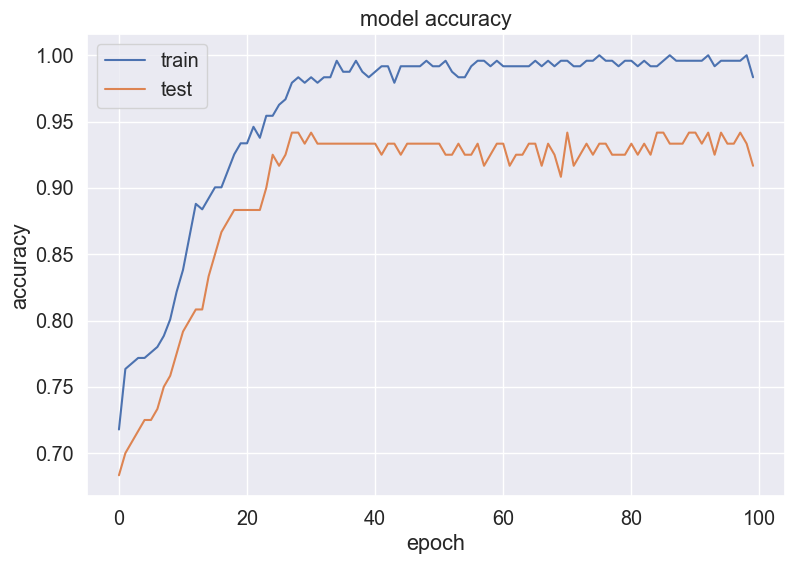

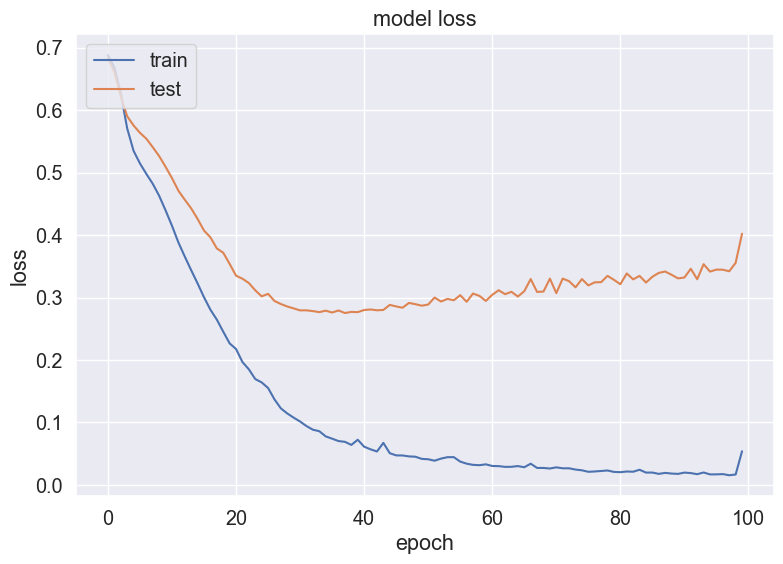

In [108]:
# summarize history for accuracy
plt.figure(figsize=(9,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(9,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [109]:
# 8.2 Predicting values from Model using same dataset


In [110]:
# generating predictions for test data
y_predict_test = model.predict(x_test)

# creating table with test price & predicted price for test
test_prediction = pd.DataFrame()
test_prediction['Test_Actual'] = y_test.size_category
test_prediction['Test_Probability'] = y_predict_test
def probToBinary(varProb):
    if varProb >= 0.5:
        return 1
    else:
        return 0

# converting the probability of target variable to binary class of test data
test_prediction['Test_Predicted'] = test_prediction['Test_Probability'].apply(probToBinary)
print(test_prediction.shape)
test_prediction.head(10)

5/5 [==============================] - 0s 0s/step
(156, 3)


,Test_Actual,Test_Probability,Test_Predicted
493,1,0.997276,1
298,0,0.001675,0
93,0,0.001916,0
437,0,0.002362,0
340,0,0.062181,0
7,0,0.001850,0
172,0,0.004262,0
76,0,0.002288,0
148,0,0.001958,0
104,0,0.001688,0


In [111]:
# generating predictions for train data
y_predict_train = model.predict(x_train)

# creating table with test price & predicted price for test
train_prediction = pd.DataFrame()
train_prediction['Train_Actual'] = y_train.size_category
train_prediction['Train_Probability'] = y_predict_train
train_prediction['Train_Predicted'] = train_prediction['Train_Probability'].apply(probToBinary)
print(train_prediction.shape)
train_prediction.head(10)

12/12 [==============================] - 0s 1ms/step
(361, 3)


,Train_Actual,Train_Probability,Train_Predicted
115,0,0.001957,0
130,0,0.002604,0
413,0,0.003037,0
350,0,0.004528,0
103,0,0.002007,0
511,0,0.002091,0
325,0,0.002283,0
473,1,0.997276,1
265,0,0.001771,0
226,1,0.997276,1


In [112]:
# 8.3 Classification Report


In [113]:
print("Accuracy score for Test Data    = ", np.round(accuracy_score(test_prediction['Test_Actual'],test_prediction['Test_Predicted']),2)*100,"%")
print("Confusion Matrix for Test Data  =\n", confusion_matrix(test_prediction['Test_Actual'],test_prediction['Test_Predicted']))
print("Classification Report for Test Data  =\n", classification_report(test_prediction['Test_Actual'],test_prediction['Test_Predicted']))

Accuracy score for Test Data    =  99.0 %
Confusion Matrix for Test Data  =
 [[113   1]
 [  0  42]]
Classification Report for Test Data  =
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       114
           1       0.98      1.00      0.99        42

    accuracy                           0.99       156
   macro avg       0.99      1.00      0.99       156
weighted avg       0.99      0.99      0.99       156



In [114]:
print("Accuracy score for Train Data    = ", np.round(accuracy_score(train_prediction['Train_Actual'],train_prediction['Train_Predicted']),2)*100,"%")
print("Confusion Matrix for Train Data  =\n", confusion_matrix(train_prediction['Train_Actual'],train_prediction['Train_Predicted']))
print("Classification Report for Train Data  =\n", classification_report(train_prediction['Train_Actual'],train_prediction['Train_Predicted']))

Accuracy score for Train Data    =  96.0 %
Confusion Matrix for Train Data  =
 [[258   6]
 [  7  90]]
Classification Report for Train Data  =
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       264
           1       0.94      0.93      0.93        97

    accuracy                           0.96       361
   macro avg       0.96      0.95      0.95       361
weighted avg       0.96      0.96      0.96       361



In [115]:
# print the scores on training and test set
y_predict_test = model.predict(x_test)
y_predict_train = model.predict(x_train)
print('Training set score : {:.2f}%'.format(accuracy_score(train_prediction['Train_Actual'], train_prediction['Train_Predicted'])*100))

print('Test set score     : {:.2f}%'.format(accuracy_score(test_prediction['Test_Actual'], test_prediction['Test_Predicted'])*100))


12/12 [==============================] - 0s 1ms/step
Training set score : 96.40%
Test set score     : 99.36%


In [116]:
# 8.4 Confusion matrix


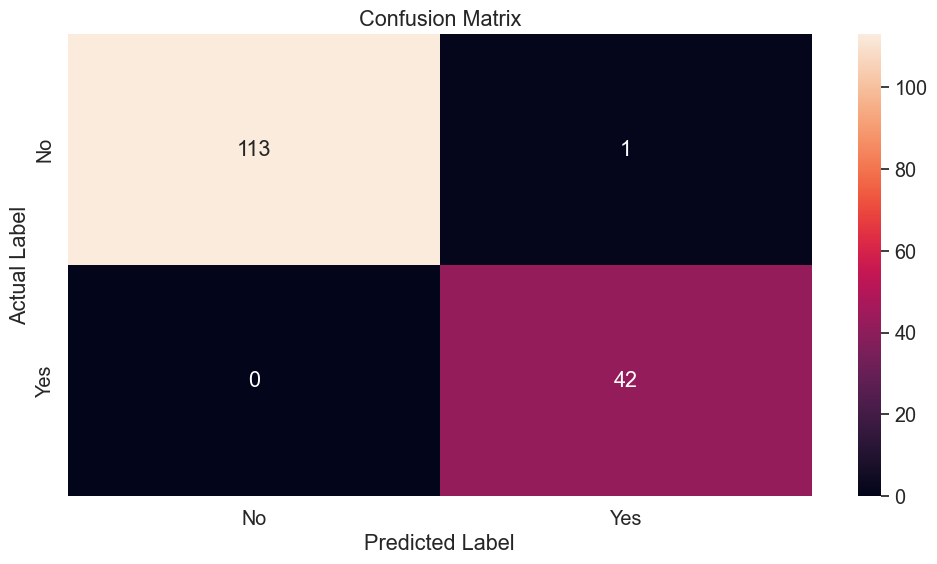

In [117]:
cm_df = confusion_matrix(test_prediction['Test_Actual'], test_prediction['Test_Predicted'])
class_label = ["No", "Yes"]
df_cm = pd.DataFrame(cm_df, index = class_label, columns = class_label)

sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [118]:
# 8.5 ROC - AUC Curve


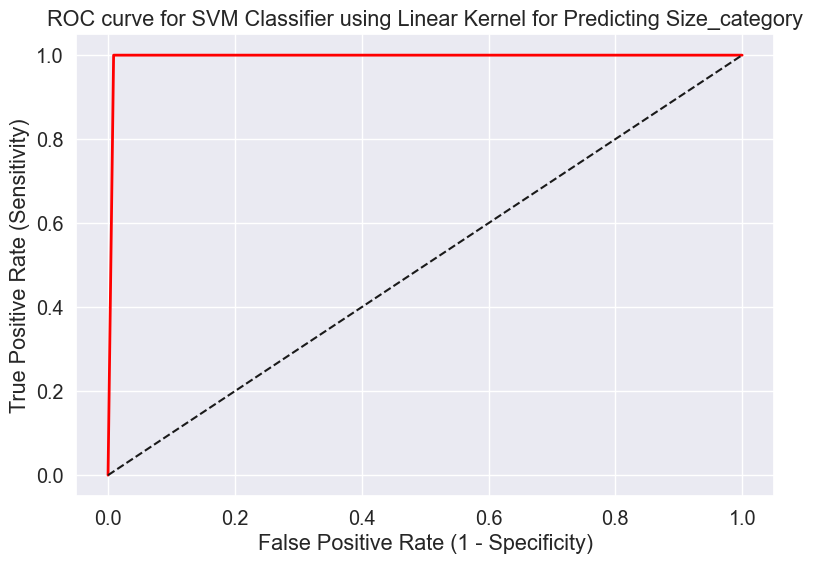

ROC AUC : 0.9956


In [119]:
plt.figure(figsize=(9,6))
fpr, tpr, thresholds = roc_curve(test_prediction['Test_Actual'], test_prediction['Test_Predicted'])
plt.plot(fpr, tpr, linewidth=2, color='red')
plt.plot([0,1], [0,1], 'k--' )
plt.title('ROC curve for SVM Classifier using Linear Kernel for Predicting Size_category')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC_AUC = roc_auc_score(test_prediction['Test_Actual'], test_prediction['Test_Predicted'])
print('ROC AUC : {:.4f}'.format(ROC_AUC))

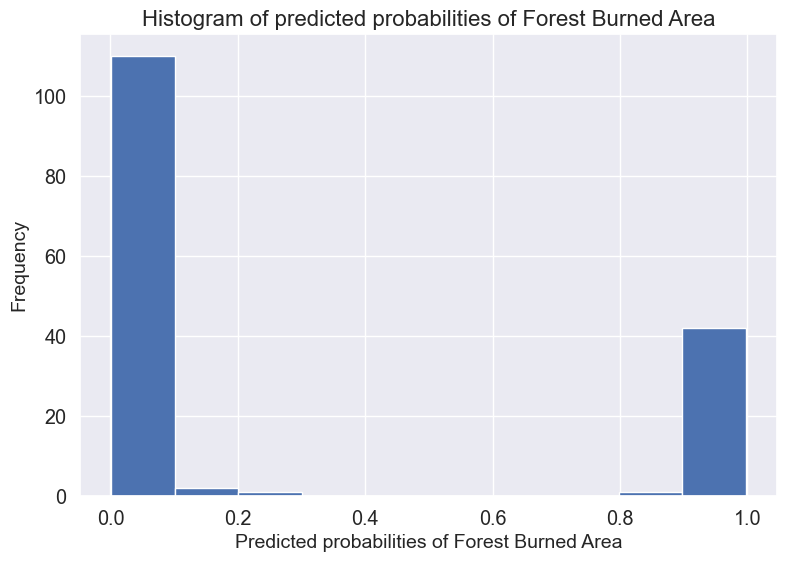

In [120]:
plt.figure(figsize=(9,6))
plt.hist(test_prediction['Test_Probability'], bins = 10)
plt.title('Histogram of predicted probabilities of Forest Burned Area', fontsize=16)
plt.xlabel('Predicted probabilities of Forest Burned Area', fontsize=14)
plt.ylabel('Frequency', fontsize=14);